# Week 03: Dimensionality Reduction and Similarities

## Text as Data

Professor: Elliott Ash, NYU

TA: Eduardo Zago, NYU

More accurate objective of the course: learning how to use text as data for research objectives, while also trying to understand how to build an LLM from scratch.

What have we done so far:

1.   Introduction to tools to manage text in Python
2.   Preprocessing of text
3.   Tokenization of text (encoder-decoder algorithms)

Now, how do we represent this tokens mathematically? And what can we do with this representations?

In [ ]:
# set random seed
import numpy as np
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
import warnings; warnings.simplefilter('ignore')
%matplotlib inline
import pandas as pd
import re
import matplotlib.pyplot as plt
from string import punctuation

!pip install gensim

import spacy
nlp = spacy.load('en_core_web_sm')

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stoplist = set(stopwords.words('english'))
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk import sent_tokenize

!pip install pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 38.5 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 29.4 MB/s eta 0:00:00


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving sc_cases_cleaned.pkl to sc_cases_cleaned.pkl


In [ ]:
df = pd.read_pickle('sc_cases_cleaned.pkl',
                    compression = 'gzip')

# Basic preprocessing for the dataset
translator = str.maketrans(' ', ' ', punctuation)
from nltk.tokenize import word_tokenize

def preprocess(doc):
  doc = doc.replace('\r', ' ').replace('\n', ' ')
  doc = re.sub(r"(\d)([A-Za-z])", r"\1 \2", doc) # separate numbers from strings
  doc = re.sub(r"([A-Za-z])(\d)", r"\1 \2", doc) # separate strings from numbers
  d = doc.translate(translator).lower() # remove punctuation
  words = word_tokenize(d)
  words = [w for w in words if w not in stoplist] # remove stopwords
  words = [w if not w.isdigit() else '#' for w in words] # normalize numbers
  output = ' '.join(words) # Let's not tokenize now
  return output

Last lab we introduced how one would represent mathemathically a corpus: term document matrix X, where

1. rows = documents
2. columns = tokens (words or n-grams)
3. values = counts

In [ ]:
preprocessed_opinion = list(map(preprocess, df['opinion_text'])) # Note list()

# Generate a date - judge index
df['index'] = df['authorship'] + df['date_standard'].astype(str)

from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(min_df=0.01,
                      max_df=.9,
                      max_features=1000)

X = vec.fit_transform(preprocessed_opinion)

vocab_opinions = vec.get_feature_names_out()
X_lab = pd.DataFrame(X.toarray(), columns=vocab_opinions, index=df['index']) # only for didactic purposes, keep only the X

X_lab

,ability,absence,absent,abuse,accept,access,according,accordingly,account,act,...,witnesses,word,words,work,writ,written,year,years,yet,york
index,,,,,,,,,,,,,,,,,,,,,
GINSBURG2003-03-04,0,1,0,0,0,0,0,0,0,6,...,0,0,7,0,5,1,3,0,0,0
STEVENS2003-06-09,0,1,0,0,0,0,0,0,0,11,...,0,0,1,0,0,0,0,0,1,0
O'CONNOR2005-03-30,1,0,1,3,0,0,0,1,0,1,...,0,0,0,0,4,0,0,1,0,0
KENNEDY2005-06-06,1,0,0,0,4,0,3,0,0,20,...,0,1,0,0,0,6,0,4,2,0
KENNEDY2005-06-13,0,0,0,0,0,2,2,0,0,1,...,7,1,0,1,0,5,3,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BREYER2001-04-18,0,0,1,0,1,0,0,1,2,0,...,0,0,1,0,0,0,0,0,2,0
SOUTER2001-04-24,0,2,2,3,0,0,2,3,3,18,...,0,0,1,0,0,1,1,6,1,9
SCALIA2001-04-24,0,0,1,0,2,0,1,0,0,12,...,0,0,0,0,1,1,1,2,1,4


Different ways of measuring similarity across text. The first one that comes to mind is the Euclidean distance:

$$\mathbf{x} = \begin{bmatrix} x_1 \\ x_2 \\ \dots \\ x_n \end{bmatrix}, \mathbf{y} = \begin{bmatrix} y_1 \\ y_2 \\ \dots \\ y_n \end{bmatrix}$$

$$\|\mathbf{x}-\mathbf{y}\| = \sqrt{\sum_{i=1}^n\left(x_i-y_i\right)^2}$$

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances #NEW

euclid = euclidean_distances(X_lab) # Computes the pairwise Euclidean distance between all rows. this is

print(euclid[0,2]) # What is this? The Euclidean distance between document 0 and document 2 in the vector space defined by the document-term matrix.

94.12226091632095


### Cosine

$$\cos θ = \frac{\mathbf{x}^{\top}\mathbf{y}}{\|\mathbf{x}\|\|\mathbf{y}\|}$$

In [ ]:
cos = cosine_similarity(X_lab)

print(cos[0,2])

0.3766859843876832


Cosine similarity is ubiquitous in NLP because almost everything reduces to comparing vectors, and cosine is a simple, scale-invariant, and empirically effective way to compare vector meaning.

Why cosine?

1) Ignores absolute magnitude

2) Focuses on direction (semantic content)

Let's look at an example:

In [ ]:
X_aug = X_lab.copy()
X_aug.loc["last_x4"] = 4 * X_lab.iloc[-1]

# 2) compare similarities/distances
cos = cosine_similarity(X_aug)
euc = euclidean_distances(X_aug)

print("Cosine similarity (last vs 4x-last):", cos[len(X_aug) - 2, len(X_aug) - 1])
print("Euclidean distance (last vs 4x-last):", euc[len(X_aug) - 2, len(X_aug) - 1])

Cosine similarity (last vs 4x-last): 0.9999999999999992
Euclidean distance (last vs 4x-last): 383.8945167620918


### tf-idf (Term Frequency–Inverse Document Frequency)

$$tfidf_{t,d} = tf_{t,d} \times \log\left(\frac{N}{df_t}\right)$$

where

$$tf_{t,d} = \frac{\text{count of } t \text{ in } d}{\sum_{t'} \text{count of } t' \text{ in } d}.$$

$df_t$ is the number of documents containing term
𝑡.

KEY CONCEPT: a word is important if...

1) it appears often in a document (high term frequency),

2) but not often across all documents (low global frequency).

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer # NEW

tfidf = TfidfVectorizer(min_df=0.01,
                        max_df=0.9,
                        max_features=1000)

X = tfidf.fit_transform(preprocessed_opinion)

X_tfidf = pd.DataFrame(X.toarray(), columns=vocab_opinions, index=df['index'])

X_tfidf

,ability,absence,absent,abuse,accept,access,according,accordingly,account,act,...,witnesses,word,words,work,writ,written,year,years,yet,york
index,,,,,,,,,,,,,,,,,,,,,
GINSBURG2003-03-04,0.000000,0.014656,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052987,...,0.000000,0.000000,0.094594,0.000000,0.099100,0.017477,0.044794,0.000000,0.000000,0.000000
STEVENS2003-06-09,0.000000,0.018466,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.122402,...,0.000000,0.000000,0.017027,0.000000,0.000000,0.000000,0.000000,0.000000,0.018435,0.000000
O'CONNOR2005-03-30,0.012637,0.000000,0.012346,0.046809,0.000000,0.000000,0.000000,0.010058,0.000000,0.007053,...,0.000000,0.000000,0.000000,0.000000,0.063316,0.000000,0.000000,0.008771,0.000000,0.000000
KENNEDY2005-06-06,0.003514,0.000000,0.000000,0.000000,0.015008,0.000000,0.008946,0.000000,0.000000,0.039222,...,0.000000,0.003526,0.000000,0.000000,0.000000,0.023286,0.000000,0.009755,0.006498,0.000000
KENNEDY2005-06-13,0.000000,0.000000,0.000000,0.000000,0.000000,0.020515,0.014892,0.000000,0.000000,0.004897,...,0.084525,0.008806,0.000000,0.009173,0.000000,0.048454,0.024838,0.006090,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BREYER2001-04-18,0.000000,0.000000,0.005965,0.000000,0.006519,0.000000,0.000000,0.004859,0.011464,0.000000,...,0.000000,0.000000,0.005214,0.000000,0.000000,0.000000,0.000000,0.000000,0.011291,0.000000
SOUTER2001-04-24,0.000000,0.006127,0.006463,0.012251,0.000000,0.000000,0.005614,0.007897,0.009315,0.033227,...,0.000000,0.000000,0.002825,0.000000,0.000000,0.003653,0.003121,0.013774,0.003058,0.032483
SCALIA2001-04-24,0.000000,0.000000,0.008075,0.000000,0.017652,0.000000,0.007015,0.000000,0.000000,0.055357,...,0.000000,0.000000,0.000000,0.000000,0.010353,0.009129,0.007800,0.011473,0.007643,0.036078


### Co-Ocurrence (term-term matrices)

Like documents, terms can also be represented using counts from a corpus. One popular method is to 'count the neighbors,' which surprisingly captures many properties about the word.

Note: "Co-occurrence matrix" is more often used in NLP, but "term-term matrix" might be more intuitive to think about in relationship to "term-document matrix."


In [ ]:
from collections import defaultdict, Counter #NEW

gins = df[df.iloc[:, 3]=='GINSBURG']
preprocess_gins = list(map(preprocess, gins['opinion_text']))

# Adapted from https://www.geeksforgeeks.org/co-occurence-matrix-in-nlp/
# Input: list of strings, window size
def get_ttm(corpus, window_size):
  # Create a list of co-occurring word pairs
  co_occurrences = defaultdict(Counter)
  all_words = []

  for article in corpus:
    words = article.split(" ") # tokenization
    all_words += words #
    for i, word in enumerate(words):
        for j in range(max(0, i-window_size), min(len(words), i+window_size+1)):
            if i != j:
                co_occurrences[word][words[j]] += 1

  # co_occurrences[w1][w2] = number of times word w2 appears within window_size of w1.
  # Create a list of unique words
  unique_words = list(set(all_words))

  # Initialize the co-occurrence matrix
  co_matrix = np.zeros((len(unique_words), len(unique_words)), dtype=int)

  # Populate the co-occurrence matrix
  word_index = {word: idx for idx, word in enumerate(unique_words)}
  for word, neighbors in co_occurrences.items():
      for neighbor, count in neighbors.items():
          co_matrix[word_index[word]][word_index[neighbor]] = count

  # Create a DataFrame for better readability
  co_matrix_df = pd.DataFrame(co_matrix, index=unique_words, columns=unique_words)

  # Return the co-occurrence matrix and word index mapping
  return co_matrix_df, word_index


# get TTM with window size 1
opinion_ttm_w1, opinion_w2i_w1 = get_ttm(preprocess_gins, 2)


In [ ]:
opinion_ttm_w1

,admitting,prescription,okay,misled,trends,nonreligious,servs850,benign,material,summarily,...,marrero,providers,spring,seeellzey,a53,abstract,convictions,holds,longexercised,nonfelony
admitting,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
prescription,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
okay,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
misled,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
trends,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
abstract,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
convictions,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
holds,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
longexercised,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# get TTM with window size 1
opinion_ttm_w1, opinion_w2i_w1 = get_ttm(preprocessed_trump, 1)

# invert dictionary: index -> word
opinion_i2w_w1 = {idx: word for word, idx in opinion_w2i_w1.items()}

# calculate cosine similarity (can take some time)
people_sim_w1 = cosine_similarity(opinion_ttm_w1)[opinion_w2i_w1["misled"]]
top_sim_locations_w1 = np.argsort(-1*people_sim_w1)  # -1 is for descending order
top10_words_w1 = [opinion_i2w_w1[i] for i in top_sim_locations_w1[:10]]  # top-1 is obviously going to be itself
top10_similarities_w1 = [people_sim_w1[i] for i in top_sim_locations_w1[:10]]
print(top10_words_w1)
print(top10_similarities_w1)

Note 2: Representations in co-occurrence matrices become more reliable with more text data (i.e. larger corpora). Because the corpus we're using today is somewhat small, the results from the example below might seem somewhat unintuitive. The main goal should be to get an idea of how to build a co-occurrence matrix and calculate similarity over it.

### Applications:

1.   Clustering (K-Means, DBSCAN, PCA)
2.   Topic Modelling (LDA, Structural Topic Modelling)

#### K-Means

K-means is an unsupervised learning algorithm used to partition data into
𝐾 clusters based on similarity.



In [ ]:
from sklearn.cluster import KMeans #NEW

#
num_clusters = 20 # Optimal number of clusters
km = KMeans(n_clusters=num_clusters)
km.fit(X_tfidf)

doc_clusters = km.labels_.tolist()

Several ways of choosing K:

1) Elbow method: look for diminishing returns in within-cluster variance.

2) Silhouette score: choose 𝐾 that maximizes cluster separation.

3) Domain knowledge.

The silhouette score provides a normalized measure of how well observations are clustered, balancing within-cluster similarity and between-cluster separation. Measures if an observation is well contained in its own cluster and away from other clusters.

In K-Means, it is a diagnostic tool rather than an optimization criterion.

In [ ]:
from sklearn.metrics import silhouette_score
silhouette_score(X_tfidf, km.labels_)

sil_scores = []
for n in range(2, num_clusters):
    km = KMeans(n_clusters=n)
    km.fit(X_tfidf)
    sil_scores.append(silhouette_score(X_tfidf, km.labels_))

opt_sil_score = max(sil_scores[5:20])
sil_scores.index(opt_sil_score)
opt_num_cluster = range(2, num_clusters)[sil_scores.index(opt_sil_score)]
print('The optimal number of clusters is %s' %opt_num_cluster)


The optimal number of clusters is 18


#### DBSCAN

DBSCAN finds dense clusters and detects outliers without pre-specifying the number of clusters.

In [ ]:
from sklearn.cluster import DBSCAN # NEW

dbscan = DBSCAN(eps=0.95, min_samples=5)
dbscan.fit(X_tfidf)
db_clusters = dbscan.labels_

df['cluster_db'] = db_clusters
df[df['cluster_db']==1]['opinion_text']

,opinion_text
17,Justice Alito delivered the opinion of the Cou...
122,Justice Ginsburg delivered the opinion of the ...
238,Chief Justice Roberts delivered the opinion of...
291,Justice Alito delivered the opinion of the Cou...
410,Justice Alito delivered the opinion of the Cou...
528,Justice Thomasdelivered the opinion of the Cou...
530,Justice Thomas delivered the opinion of the Co...
685,JUSTICE GINSBURG delivered the opinion of the ...
769,CHIEF JUSTICE REHNQUIST delivered the opinion ...


#### PCA

Everything is SVD: PCA (Principal Component Analysis) is a dimensionality-reduction method that finds the directions of maximum variance in the data.

Computes the SVD of the normalized covariate matrix.

In [ ]:
from sklearn.decomposition import PCA # NEW

pca_tfidf = PCA()

pca_tfidf.fit(X_tfidf)

cumvar_tfidf = np.cumsum(pca_tfidf.explained_variance_ratio_)

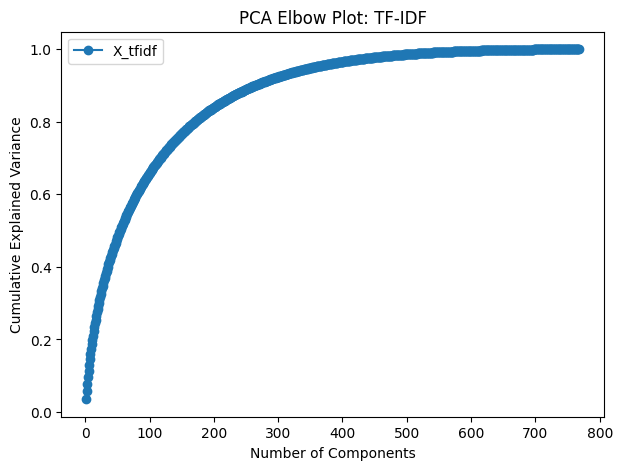

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(range(1, len(cumvar_tfidf)+1), cumvar_tfidf, marker='o', label="X_tfidf")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Elbow Plot: TF-IDF")
plt.legend()
plt.show()


Is this a good elbow plot? What is the conclusion that we get from this?

With text data, elbows are often weak or smooth (Why?)

### Topic Modelling

#### LDA (Latent Dirichlet Allocation)

LDA is a probabilistic topic model used to discover latent topics in a collection of documents.

Topics are latent (unobserved) and inferred from word co-occurrence patterns.

In [ ]:
# split into paragraphs
doc_clean = []
for doc in preprocessed_opinion:
    # split by paragraph
    for paragraph in doc.split("\n\n"):
        doc_clean.append(doc.split())
print(doc_clean[:2])

[['justice', 'ginsburg', 'delivered', 'opinion', 'court', 'motion', 'federal', 'prisoner', 'postconviction', 'relief', '#', 'usc', '§', '#', 'subject', 'oneyear', 'time', 'limitation', 'generally', 'runs', 'date', 'judgment', 'conviction', 'becomes', 'final', '§', '#', 'p', '#', 'case', 'concerns', 'starting', 'date', 'oneyear', 'limitation', 'presents', 'narrow', 'recurring', 'question', 'courts', 'appeals', 'divided', 'defendant', 'federal', 'prosecution', 'takes', 'unsuccessful', 'direct', 'appeal', 'judgment', 'conviction', 'next', 'petition', 'writ', 'certiorari', 'court', 'judgment', 'become', 'final', 'postconviction', 'relief', 'purposes', '#', 'appellate', 'court', 'issues', 'mandate', 'affirming', 'conviction', 'instead', '#', 'date', 'ordinarily', '#', 'days', 'later', 'time', 'filing', 'petition', 'certiorari', 'expires', 'accord', 'courts', 'consistent', 'understanding', 'finality', 'context', 'collateral', 'review', 'weight', 'lower', 'court', 'authority', 'reject', 'issu

In [ ]:
# randomize document order
from random import shuffle
shuffle(doc_clean)

# creating the term dictionary
from gensim import corpora # New
dictionary = corpora.Dictionary(doc_clean)
# filter extremes, drop all words appearing in less than 10 paragraphs and all words appearing in at least every third paragraph
dictionary.filter_extremes(no_below=10, no_above=0.33, keep_n=1000)
print(len(dictionary))

1000


In [ ]:
import warnings

warnings.filterwarnings(
    "ignore",
    message="datetime.datetime.utcnow",
    category=DeprecationWarning
)

# creating the document-term matrix
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

# train LDA with 10 topics and print
from gensim.models.ldamodel import LdaModel
lda = LdaModel(doc_term_matrix, num_topics=14,
               id2word = dictionary, passes=3)
lda.show_topics(formatted=True)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

[(np.int64(13),
  '0.017*"foreign" + 0.012*"charge" + 0.011*"limitations" + 0.009*"commission" + 0.009*"jurisdictional" + 0.009*"filing" + 0.008*"international" + 0.007*"california" + 0.006*"primary" + 0.006*"plaintiffs"'),
 (np.int64(7),
  '0.023*"city" + 0.016*"standing" + 0.011*"injury" + 0.009*"foreign" + 0.008*"value" + 0.008*"plaintiffs" + 0.008*"injunction" + 0.007*"tax" + 0.007*"equitable" + 0.007*"claimed"'),
 (np.int64(10),
  '0.016*"employees" + 0.013*"board" + 0.012*"commerce" + 0.010*"fees" + 0.009*"prison" + 0.009*"employment" + 0.008*"funds" + 0.008*"employee" + 0.007*"activity" + 0.006*"local"'),
 (np.int64(6),
  '0.026*"tax" + 0.018*"program" + 0.014*"school" + 0.008*"services" + 0.008*"funds" + 0.008*"regulation" + 0.007*"local" + 0.007*"material" + 0.006*"consent" + 0.006*"aid"'),
 (np.int64(1),
  '0.052*"plan" + 0.015*"political" + 0.015*"fees" + 0.013*"attorney" + 0.011*"attorneys" + 0.008*"benefits" + 0.008*"regulations" + 0.007*"washington" + 0.006*"regulation" +

Topic–word distributions (what defines each topic).

In [ ]:

import pyLDAvis.gensim
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda, doc_term_matrix, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.081106  0.032081       1        1  12.609290
11     0.108329 -0.009893       2        1  10.155087
6     -0.049325 -0.022673       3        1   9.799521
2      0.033820 -0.042589       4        1   8.771451
5     -0.014219  0.000572       5        1   7.777443
12    -0.022017  0.018902       6        1   7.750548
13    -0.018149  0.047831       7        1   7.130893
9     -0.041730 -0.008382       8        1   6.551767
1     -0.022317 -0.039945       9        1   5.390107
7     -0.020979  0.027668      10        1   5.343379
3     -0.013992  0.029323      11        1   5.214448
10     0.000913 -0.016305      12        1   5.119845
4     -0.028891  0.000768      13        1   4.849060
8      0.007452 -0.017358      14        1   3.537161, topic_info=            Term         Freq        Total Category  logprob  loglift
330         plan  2033.000000  2033.000000  Default  30.0000  30.0000
906       habeas  1986.000000  1986.000000  Default  29.0000  29.0000
404          tax  1967.000000  1967.000000  Default  28.0000  28.0000
996   sentencing  1507.000000  1507.000000  Default  27.0000  27.0000
40       damages  1492.000000  1492.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
357   regulation    62.262389  1531.649979  Topic14  -5.4056   0.1391
218        costs    48.217874   907.481406  Topic14  -5.6612   0.4069
973        crime    55.353552  1597.575181  Topic14  -5.5232  -0.0207
373    secretary    45.207647   890.281375  Topic14  -5.7257   0.3616
291  limitations    46.977910  1089.535041  Topic14  -5.6873   0.1980

[635 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
603       1  0.076921  access
603       2  0.058973  access
603       3  0.265377  access
603       4  0.049999  access
603       5  0.147432  access
...     ...       ...     ...
160      10  0.147871    york
160      11  0.107542    york
160      12  0.037640    york
160      13  0.028230    york
160      14  0.048394    york

[4900 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 12, 7, 3, 6, 13, 14, 10, 2, 8, 4, 11, 5, 9])

In [ ]:
from gensim.models.coherencemodel import CoherenceModel

coherence_scores = []
for k in range(1, 10):
    lda = LdaModel(
        corpus=doc_term_matrix,
        num_topics=k,
        id2word=dictionary,
        passes=3,
        random_state=0
    )

    cm = CoherenceModel(
        model=lda,
        texts=doc_clean,
        dictionary=dictionary,
        coherence='c_v'
    )

    coherence_scores.append(cm.get_coherence())




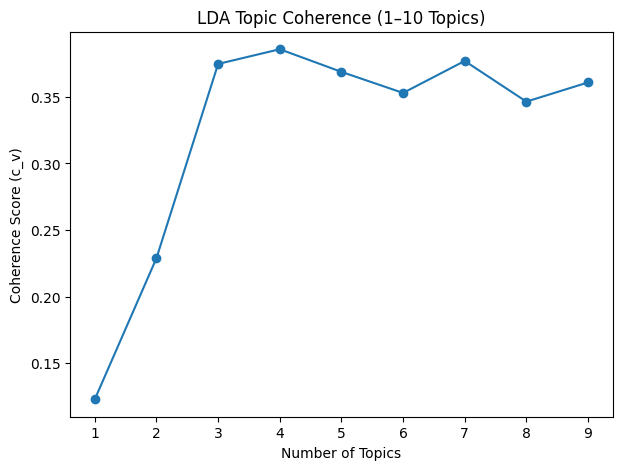

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(range(1,10), coherence_scores, marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score (c_v)")
plt.title("LDA Topic Coherence (1–10 Topics)")
plt.show()

#### Author Topic Model (Structural Topic Model)

Like LDA but STM provides two ways to include contextual information:

1) Topic prevalence
2) Topic content

Certain judges might talk about a certain issue more (prevalence), or more enthusiastically (content)

In [ ]:
from gensim.models import AuthorTopicModel
from gensim.test.utils import temporary_file

df = df.reset_index()
df['id'] = df.index
author2doc = df[:100][['authorship','id']]
author2doc = author2doc.groupby('authorship').apply(lambda x: list(x['id'])).to_dict()

model = AuthorTopicModel(
        doc_term_matrix, author2doc=author2doc, id2word=dictionary, num_topics=10)

# For each author list topic distribution
author_vecs = [model.get_author_topics(author) for author in model.id2author.values()]
author_vecs[:2]

[[(0, np.float64(0.11926551155450954)),
  (1, np.float64(0.13096219891323457)),
  (3, np.float64(0.5330217768478394)),
  (4, np.float64(0.15415148411912735)),
  (6, np.float64(0.03648530504065384)),
  (9, np.float64(0.026029006149496825))],
 [(0, np.float64(0.3965324089614805)),
  (1, np.float64(0.01527202171716403)),
  (2, np.float64(0.4441494710510663)),
  (6, np.float64(0.06250658034947025)),
  (8, np.float64(0.08142597633564891))]]